In [ ]:
import numpy as np
import math

## Ｌoss函数

In [ ]:
def svm_loss(x,y):
    '''
    svm损失函数
    输入:
    C为标签数目
    x为神经网络得到的结果值，（N,C)
    y为标签,(N,)
    output：
    loss，svm损失
    dx，反向传播值
    '''
    N = x.shape[0]
    z = x[np.arange(N),y]
    margin = np.maximum(0,x - z[:,np.newaxis] + 1)
    margin[np.arange(N),y] = 0
    loss = np.sum(margin)
    loss = loss/N
    num_pos = np.sum(margin>0,axis = 1)
    dx = np.zeros_like(x)
    dx[margin > 0] = 1
    dx[np.arange(N),y] -= num_pos
    dx /= N
    return loss,dx

In [ ]:
def softmax_loss(x,y):
    '''
    softmax损失函数
    input:
    C为标签数目
    x为神经网络得到的结果值，（N,C)
    y为标签,(N,)
    output：
    loss，softmax损失
    dx，反向传播值
    '''
    N= x.shape[0]
    margin = x - np.max(x,axis = 1,keepdims = True)
    exp_margin = np.exp(margin)
    msum = np.sum(exp_margin,axis = 1,keepdims = True)
    log_probs = margin - np.log(msum)                # 防止分母太小，转化成减得形式
    probs = np.exp(log_probs)
    loss = -np.sum(log_probs[np.arange(N),y])
    loss = loss/N

    
    dx = probs.copy()
    dx[np.arange(N),y] -= 1
    dx /= N
    return loss,dx

## 激活函数

In [ ]:
def sigmoid_forward(x):
    exp_x = np.exp(-x)
    out = 1/(1 + exp_x)
    cache = (x,out)
    return out,cache

In [ ]:
def sigmoid_backward(dout,cache):
    x,y = cache
    dx = dout * y * (1-y)
    return dx

In [ ]:
def relu_forward(x):
    out = np.maximum(0,x)
    cache = (x,out)
    return out,cache

In [ ]:
def relu_backward(dout,cache):
    x,y = cache
    dx = dout.copy()
    dx[x<0] = 0
    return dx

In [ ]:
def tanh_forward(x):
    exp_plus_x = np.exp(x-np.max(abs(x)))
    exp_neg_x = np.exp(-x-np.max(abs(x)))
    out = (exp_plus_x - exp_neg_x)/(exp_plus_x + exp_neg_x)
    cache = (x,out)
    return out,cache

In [ ]:
def tanh_backward(dout,cache):
    x,y = cache
    dx = (1 + y ** 2)*dout
    return dx

## 梯度下降

In [ ]:
def sgd(w,dw,config):
    '''
    Inputs:
    -w:需要更新的参数
    -dw:更新的梯度
    -config:该梯度下降方法的各项参数
    '''
    
    lr = config.get('lr',1e-5)
    next_w = w - lr * dw
    
    return next_w

In [ ]:
def momentum(w,dw,config):
    '''
    Inputs:
    -w:需要更新的参数
    -dw:更新的梯度
    -config:该梯度下降方法的各项参数
    '''
        
    v = config.get('v',np.zeros_like(w))
    momentum = config.get('momentum',0.9)
    lr = config.get('lr',1e-5)
    v = momentum * v - lr * dw
    next_w = w + v
    config['v'] = v
    
    return next_w

In [ ]:
def rmsprop(w,dw,config):
    '''
    Inputs:
    -w:需要更新的参数
    -dw:更新的梯度
    -config:该梯度下降方法的各项参数
    '''
    
    s = config.get('s',np.zeros_like(w))
    decay_rate = config.get('decay_rate',0.99)
    eps = config.get('eps',1e-6)
    lr = config.get('lr',1e-5)
    
    s = decay_rate * s + (1 - decay_rate) * (dw **2)
    next_w = w - lr * dw * (s** (0.5) + eps) **(-1)
    config['s'] = s
    
    return next_w

In [ ]:
def adam(w,dw,config):
    '''
    Inputs:
    -w:需要更新的参数
    -dw:更新的梯度
    -config:该梯度下降方法的各项参数
    '''
    v = config.get('v',np.zeros_like(w))
    momentum = config.get('momentum',0.9)
    s = config.get('s',np.zeros_like(w))
    decay_rate = config.get('decay_rate',0.99)
    eps = config.get('eps',1e-6)
    lr = config.get('lr',1e-5)
    v = (momentum * v + (1 - momentum) * dw)/(1-momentum)
    s = (decay_rate * s + (1- decay_rate) * (dw ** 2))/(1-decay_rate)
    
    next_w = w - lr * v * (s** (0.5) + eps) **(-1)
    
    config['s'] = s
    config['v'] = v
    
    return next_w

## batch_normalization

In [ ]:
def norm_forward(x,gamma,beta,bn_param):
    '''
    Inputs:
    -x:(N,D)
    -gamma:(D,)
    -beta:(D,)
    -bn_param:字典
        -mode:'train' or 'test'
        -eps:默认1e-8
        -momentum
        -running_mean
        -running_var
    '''
    eps = bn_param['eps']
    running_mean = bn_param['running_mean']
    running_var = bn_param['running_var']
    momentum = bn_param['momentum']
    mode = bn_param['mode']
    if mode == 'train':
        sample_mean = np.mean(x,axis = 0)
        sample_var = np.var(x,axis = 0)
        x_hat = (x - sample_mean)/(np.sqrt(sample_var + eps))
        out = gamma * x_hat + beta
        running_mean = momentum * running_mean + (1-momentum) * sample_mean
        running_var = momentum * running_var + (1-momentum)*sample_var
        bn_param['running_mean'] = running_mean
        bn_param['running_var'] = running_var 
        cache = (x,gamma,beta,x_hat,sample_mean,sample_var,eps)
        return out,cache
    elif mode == 'test':
        out = gamma * (x - running_mean)/(np.sqrt(running_var + eps)) + beta
        return out,None
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

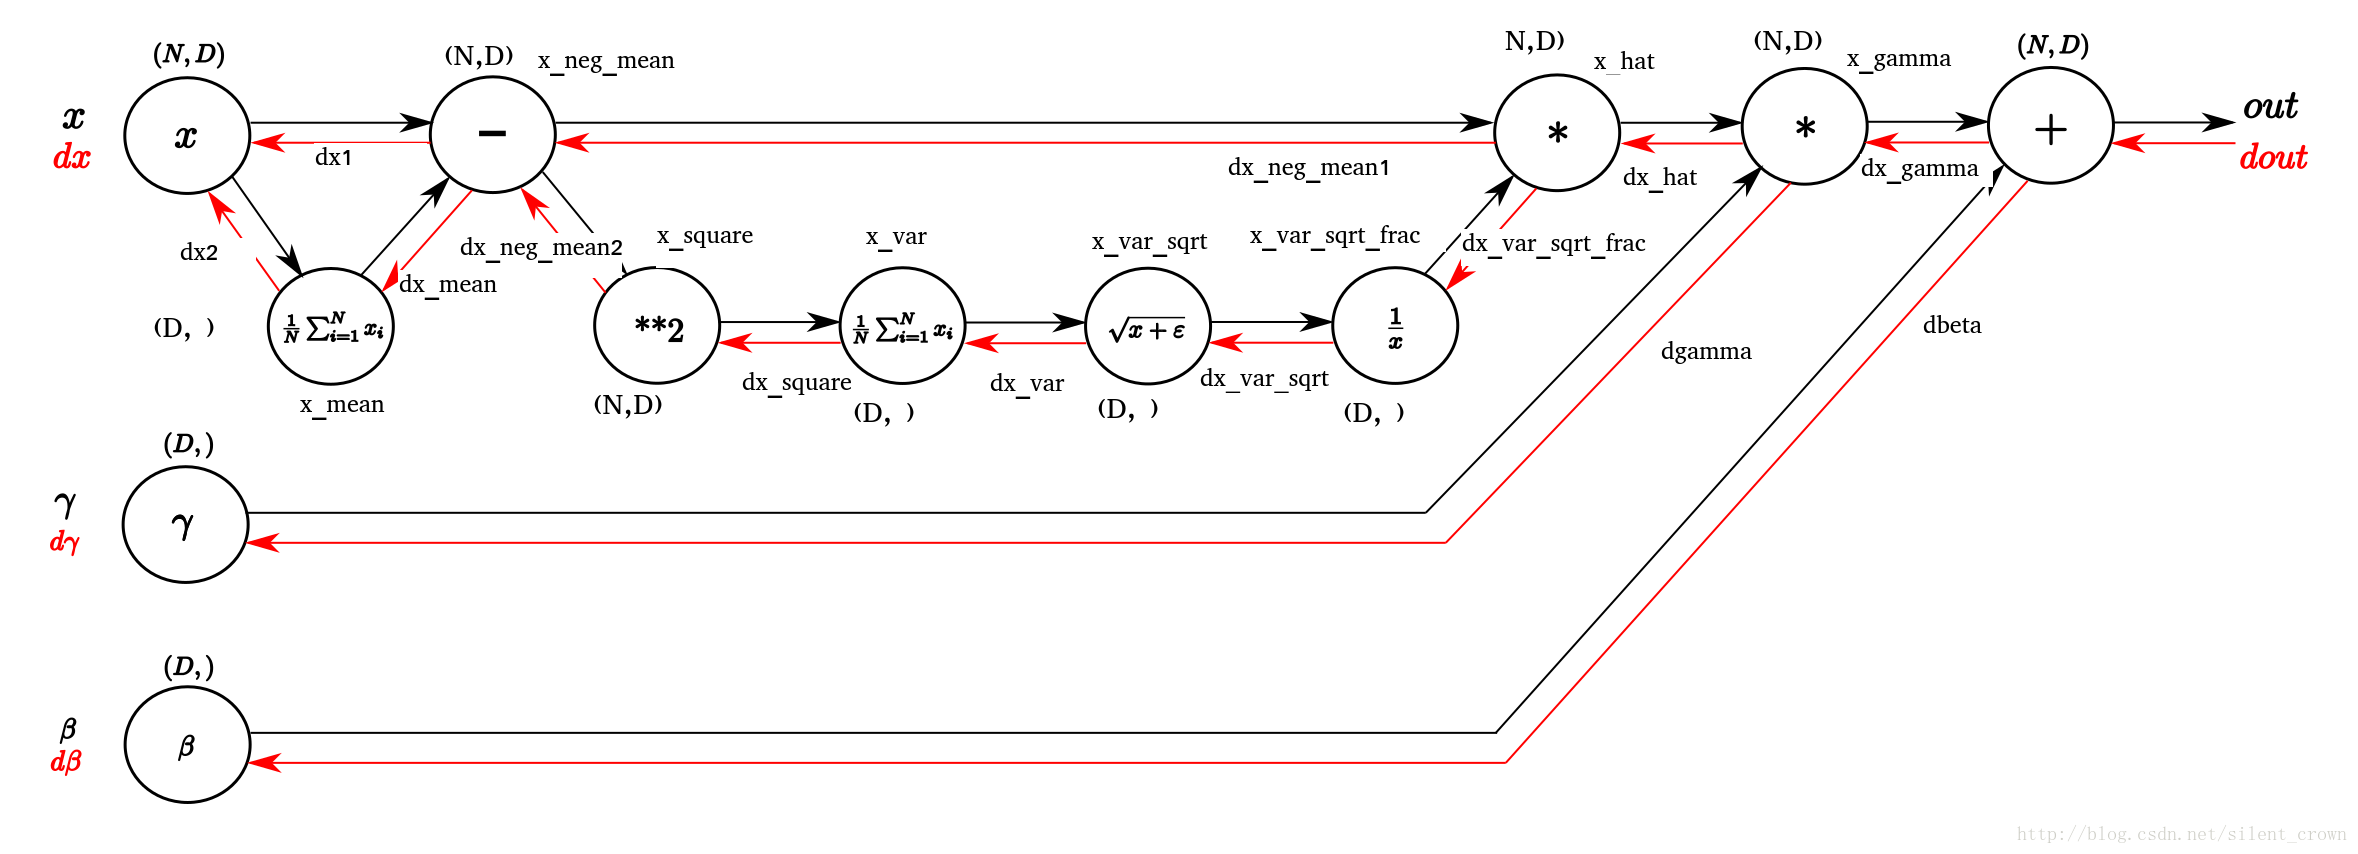

In [ ]:
def norm_backward(dout,cache):
    N,D = dout.shape
    x,gamma,beta,x_hat,sample_mean,sample_var,eps = cache
    dx_gamma = dout
    dbeta = np.sum(dout,axis = 0)
    dx_hat = dx_gamma * gamma
    dgamma = np.sum(dx_gamma * x_hat,axis = 0)
    x_var_sqrt_frac = 1/(np.sqrt(sample_var + eps))
    dx_neg_mean1 = dx_hat * x_var_sqrt_frac
    x_neg_mean = x - sample_mean
    dx_var_sqrt_frac = dx_hat * x_neg_mean
    x_var_sqrt = np.sqrt(sample_var + eps)
    dx_var_sqrt = -1/(x_var_sqrt ** 2) * dx_var_sqrt_frac
    dx_var = 1/(2 * x_var_sqrt) * dx_var_sqrt
    dx_square = 1/N * np.ones((N,D)) * dx_var
    x_neg_mean = x - sample_mean
    dx_neg_mean2 = 2 * x_neg_mean * dx_square
    dx_neg_mean = dx_neg_mean1 + dx_neg_mean2
    dx1 = dx_neg_mean
    dx_mean = np.sum(-dx_neg_mean,axis = 0)
    dx2 = 1/N * np.ones((N,D)) * dx_mean
    dx = dx1 + dx2
    return dx,dgamma,dbeta

In [ ]:
def spatial_batchnorm_forward(x,gamma,beta,bn_param):
    '''
    空间标准化，用于CNN中对数据进行标准化
    
    Inputs:
    -x:(N,H,W,C)
    -gamma:(C,)
    -beta:(C,)
    -bn_param:字典
        -mode:'train' or 'test'
        -eps:默认1e-8
        -momentum
        -running_mean
        -running_var
    
    Outputs:
    -out:输出数据,(N,C,H,W)
    -cache:(x,gamma,beta,x_hat,sample_mean,sample_var,eps)
    '''
    
    N,H,W,C = x.shape
    x_new = x.reshape(N*H*W,C)
    out,cache = norm_forward(x_new,gamma,beta,bn_param)
    out = out.reshape(N,H,W,C)
    
    return out,cache

In [ ]:
def spatial_batchnorm_backward(dout,cache):
    '''
    Inputs:
    -dout:梯度(N,H,W,C)
    -cache:(x,gamma,beta,x_hat,sample_mean,sample_var,eps)
    '''
    N,H,W,C = dout.shape
    dout_new = dout.reshape(N*H*W,C)
    dx,dgamma,dbeta = norm_backward(dout_new,cache)
    dx = dx.reshape(N,H,W,C)
    
    return dx,dgamma,dbeta

## dropout

In [ ]:
def dropout_forward(x,dp_param):
    p = dp_param['dropout']
    mode = dp_param['mode']
    
    if mode == 'train':
        keep_prob = 1-p
        mask = (np.random.randn(*x.shape) < keep_prob)/keep_prob
        out = mask * x
        cache = (mask)
        return out,cache
    elif mode == 'test':
        out = x
        return out,None
    else:
        raise ValueError('Invalid dropout mode "%s"' % mode)

In [ ]:
def dropout_backward(dout,cache):
    mask = cache
    dx = dout * mask
    return dx